<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Project: Whether a loan is paid off</font></h1>
<h2 align="center"><font size="5">Deadline: 2020-11-29 18:00:00</font></h2>
<h3 align="center"><font size="5"> Total marks: 6.0</font></h3>

### Your information:
- Fullname: Trần Hoàng Bách

- Date of birth: 01/10/1993

- Email: bach.tranhoang@gmail.com

- Mobile phone: 0985878108

## Import liabraries

In [32]:
# General tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sb
%matplotlib inline
import time
import itertools

# Pre-processing tools
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn import over_sampling, under_sampling, combine

# Metrics for testing result
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, GridSearchCV, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier

## About dateset
This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

## Load and check data

In [4]:
df = pd.read_csv('LDS5_261_Project_1/loan_train.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['due_date'] = pd.to_datetime(df['due_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     346 non-null    object        
 1   Principal       346 non-null    int64         
 2   terms           346 non-null    int64         
 3   effective_date  346 non-null    datetime64[ns]
 4   due_date        346 non-null    datetime64[ns]
 5   age             346 non-null    int64         
 6   education       346 non-null    object        
 7   Gender          346 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 21.8+ KB


In [6]:
# Create a function to evaluate missing in data, check unique in object (categorical col)
def check_data(df):
    check = []
    for col in df.columns:
        type = df[col].dtypes
        if type == 'object':
            unique_obj = df[col].unique()
        else:
            unique_obj = ''
        total_nan = df[col].isnull().sum()
        percent_nan = total_nan/len(df[col])
        check.append([col, type, total_nan, percent_nan, unique_obj])
    check_df = pd.DataFrame(check, columns=['Col', 'Type', 'Total_NaN', 'Percent', 'Unique'])
    return check_df
    
check_data(df)

,Col,Type,Total_NaN,Percent,Unique
0,loan_status,object,0,0.0,"[PAIDOFF, COLLECTION]"
1,Principal,int64,0,0.0,
2,terms,int64,0,0.0,
3,effective_date,datetime64[ns],0,0.0,
4,due_date,datetime64[ns],0,0.0,
5,age,int64,0,0.0,
6,education,object,0,0.0,"[High School or Below, Bechalor, college, Mast..."
7,Gender,object,0,0.0,"[male, female]"


## Identify Variables, Feature Extraction

In [7]:
# Geting week, dayofweek, day from effective date and due_date
def get_more_variable(df):
    df_new = df.copy()
    df_new['eff_month'] = df_new['effective_date'].dt.month
    df_new['eff_day'] = df_new['effective_date'].dt.day
    df_new['eff_dayofweek'] = df_new['effective_date'].dt.dayofweek
    df_new['eff_weekofmonth'] = (df_new['eff_day'] - 1) // 7 + 1

    df_new['due_month'] = df_new['due_date'].dt.month
    df_new['due_day'] = df_new['due_date'].dt.day
    df_new['due_dayofweek'] = df_new['due_date'].dt.dayofweek
    df_new['due_weekofmonth'] = (df_new['due_day'] - 1) // 7 + 1

    return df_new

df = get_more_variable(df)

cate_visual = ['education', 'Gender', 'eff_day', 'eff_dayofweek', 'eff_weekofmonth', 'due_day', 'due_dayofweek', 'due_weekofmonth', 'eff_month', 'due_month']
num_visual = ['age', 'Principal', 'terms']
target_col = 'loan_status'

order_sort = {'education': ['High School or Below', 'college', 'Bechalor', 'Master or Above']}
order_rename = {'eff_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'due_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

# Set color specific consistant for all charts
d = len(df[target_col].unique())
c_palette = sb.color_palette('colorblind')
colors = [c_palette[i] for i in range(d-1, -1, -1)]

df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,eff_month,eff_day,eff_dayofweek,eff_weekofmonth,due_month,due_day,due_dayofweek,due_weekofmonth
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,9,8,3,2,10,7,4,1
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,9,8,3,2,10,7,4,1
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,9,8,3,2,9,22,3,4
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,9,9,4,2,10,8,5,2
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,9,9,4,2,10,8,5,2


In [8]:
# Prepare X_test, y_test
df_test = pd.read_csv('LDS5_261_Project_1/loan_test.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
df_test['due_date'] = pd.to_datetime(df_test['due_date'])
df_test = get_more_variable(df_test)

## Univariate Analysis

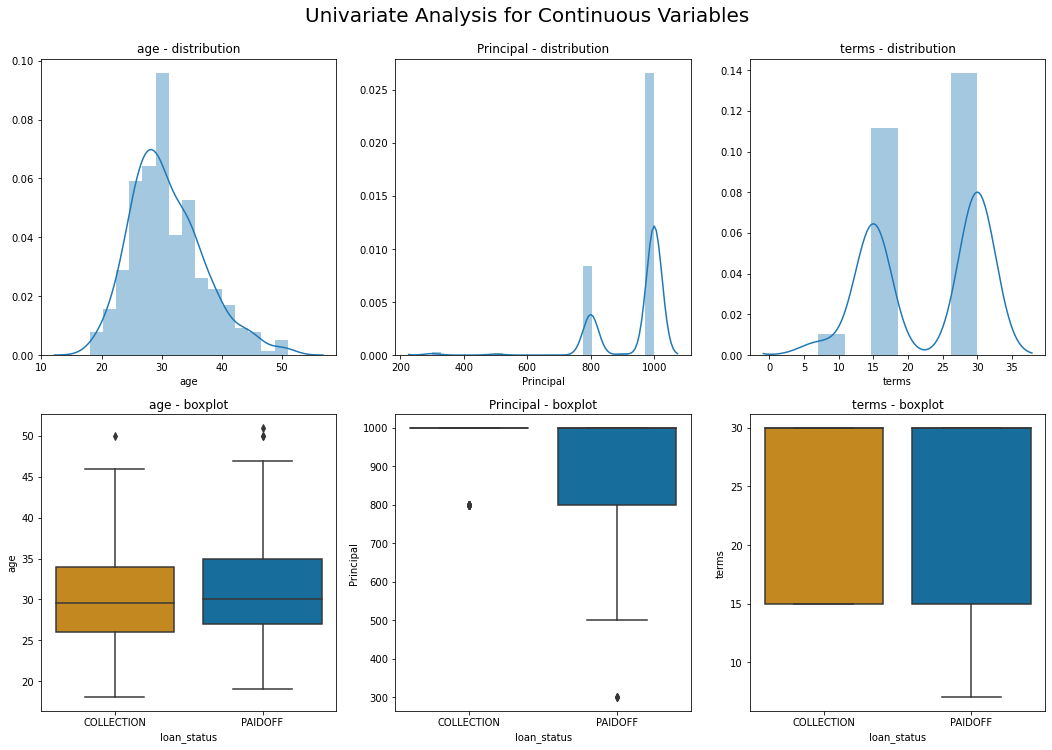

In [9]:
# Write a function display charts for continous variables: displot and boxplot
def plot_univariate_analysis_continuous_variables(df, num_col, target_col, size_height=6, size_width=6):
    # Setup chart
    n = len(num_col)
    d = len(df[target_col].unique())
    c_palette = sb.color_palette('colorblind')
    colors = [c_palette[i] for i in range(d-1, -1, -1)]
    fig, axes = plt.subplots(2, n, figsize=(size_height*n, size_width*2))
    i = 1

    # Draw displot on first row
    for col in num_col:
        plt.subplot(2, n, i)
        sb.distplot(df[col])
        plt.title(col+ ' - distribution')
        i += 1

    # Draw boxplot with hue on target_col on second row
    for col in num_col:
        plt.subplot(2, n, i)
        sb.boxplot(data=df.sort_values(target_col), y=col, x=target_col, palette=colors)
        plt.title(col+ ' - boxplot')
        i += 1
    fig.suptitle('Univariate Analysis for Continuous Variables', y=0.94, size=20)
    plt.show()

plot_univariate_analysis_continuous_variables(df, num_visual, target_col)

### Univariance Analysis on Continuous Variables
#### Age: 
- Have good shape sample, nearly normal distribution

- Have litle 2-3 outliers, but outliers is okie because having people 50 years old is not abnormal

- Not difference between age and loan_status

#### Principal:
- Not like a quantitative variable since only 4 unique values: 300, 500, 800, 1000.

- Seem most COLLECTION are at Principal 1000, and 1 on 800

- Suggest treat Principal like Quanlitative variable because too little unique value and plot count bar for easier see difference in loan status

#### Terms:
- Also like Principal, only 3 unique values: 7, 15, 30.

- Not difference in when split by loan_status

- Suggest treat Terms like Quanlitative variable.

In [10]:
cate_visual = ['Principal', 'terms'] + cate_visual

In [11]:
def plot_category_count_hue_stacked(df, x_col, target_col, order_sort, order_rename, ax=None):
    # Create group-data for plot
    df_plot = df.groupby([x_col, target_col]).size().reset_index().pivot(index=x_col, columns=target_col, values=0).fillna(0)

    # Create order_sort if we want
    try:
        order_sort_x = order_sort[x_col]
    except Exception:
        order_sort_x = np.sort(df[x_col].unique())

    # df_plot.reindex(order_sort_x)
    # df_plot = df_plot.loc[order_sort_x]
    # Main Plot function
    plot = df_plot.reindex(order_sort_x).plot(kind='bar', stacked=True, rot=0, color=colors, ec='k', width=0.8, ax=ax)

    # Create order_rename if we want
    try:
        order_rename_x = order_rename[x_col]
        plot.set_xticklabels(order_rename_x)
    except Exception:
        pass

    # Write function to plot number about data on each bar
    try:
        bar_patches = np.reshape(plot.patches, (2,-1)).T
        for bot, top in bar_patches:
            height_bot = bot.get_height()
            height_top = bot.get_height() + top.get_height()
            plot.text(bot.get_x() + bot.get_width()/2, height_bot*0.2, '%d' % int(bot.get_height()), ha='center', va='bottom')
            plot.text(top.get_x() + top.get_width()/2, height_top*0.7, '%d' % int(top.get_height()), ha='center', va='bottom')
    except Exception:
        pass
    return plot
## Test plot
# plot_category_count_hue_stacked(df, 'eff_dayofweek', target_col, order_sort, order_rename)

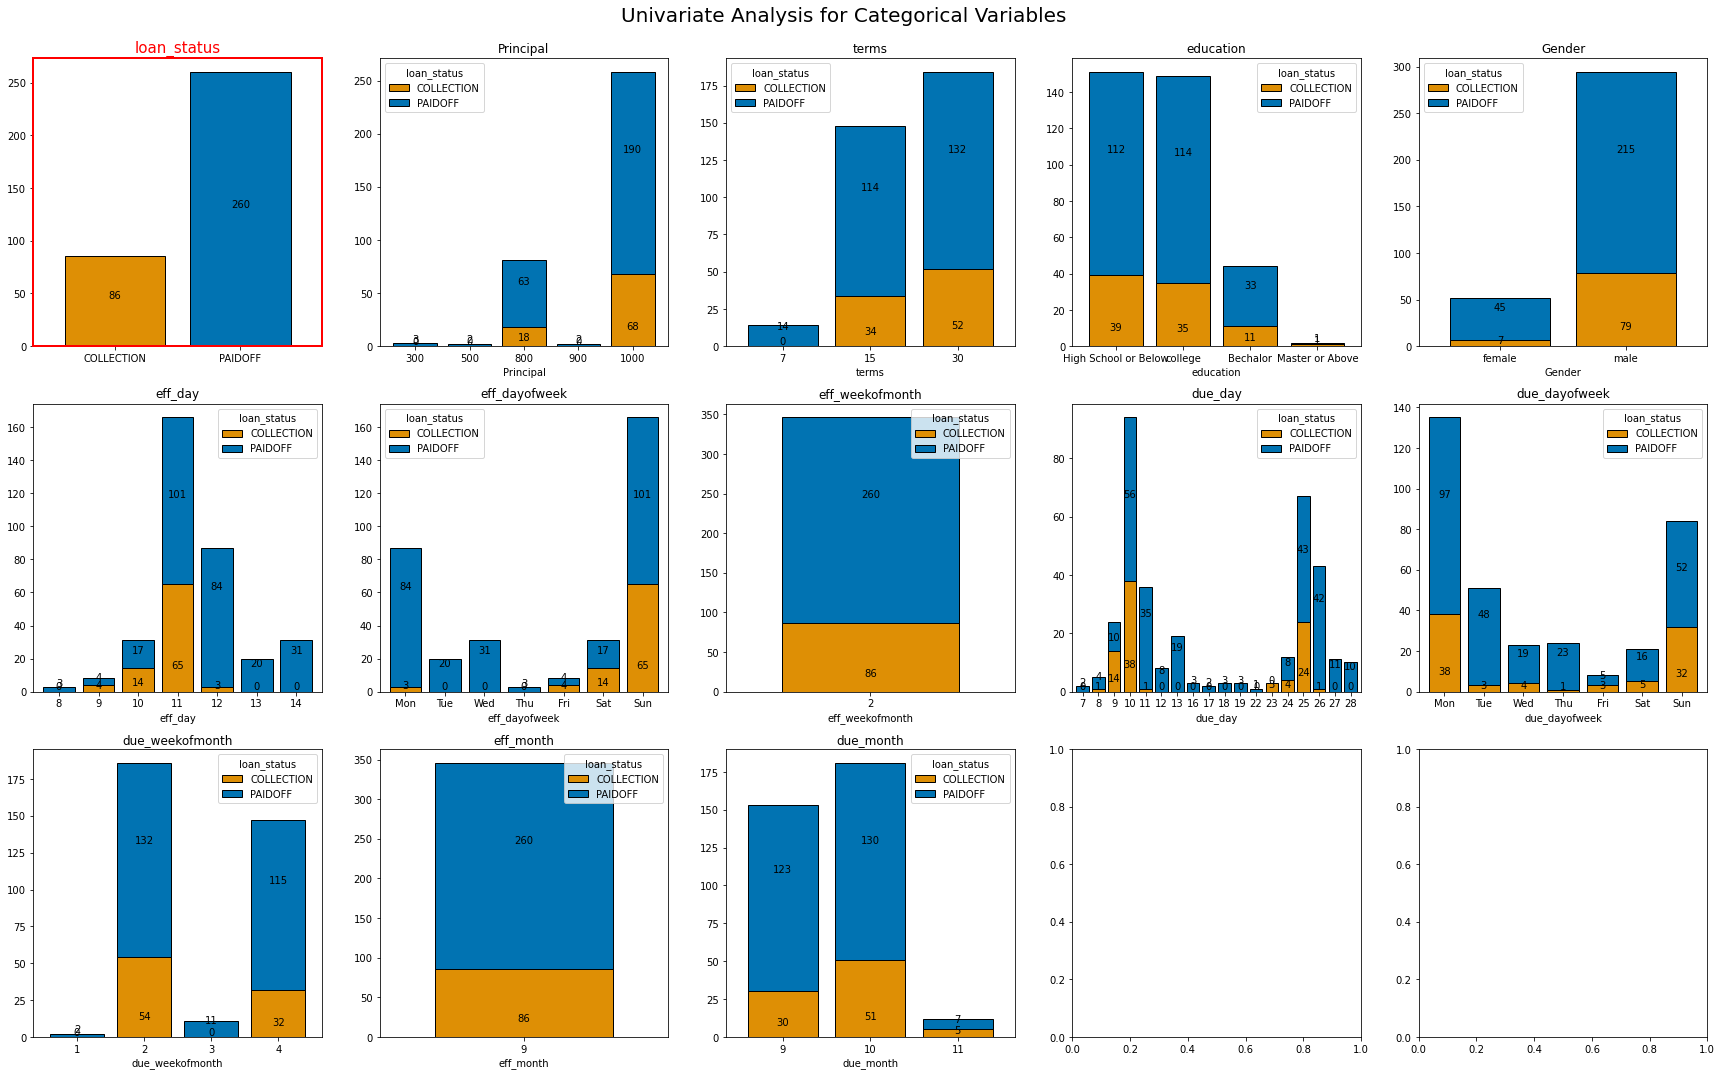

In [12]:
def plot_univariate_analysis_categorical_variables(df, cate_col, target_col, order_sort, order_rename, n_max_col=4, size_height=6, size_width=6):
    # Setup chart
    n_cate = len(cate_col) + 1
    n = min(n_max_col, n_cate)
    m = (n_cate - 1) // n + 1

    d = len(df[target_col].unique())
    c_palette = sb.color_palette('colorblind')
    colors = [c_palette[i] for i in range(d-1, -1, -1)]

    fig, axes = plt.subplots(m, n, figsize=(n*6, m*6))
    axes_total = axes.ravel()

    # Plot target_col
    df_target_plot = df[target_col].value_counts().sort_index()
    plot_target = df_target_plot.plot(kind='bar', color=colors, rot=0, ec='k', width=0.8, ax=axes_total[0])
    plot_target.set_title(target_col, size=15, color='r')
    for bar in plot_target.patches:
        plot_target.text(bar.get_x() + bar.get_width()/2, (bar.get_height())*0.5, '%d' % int(bar.get_height()), ha='center', va='bottom')
    for spine in axes_total[0].spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2)

    # Main Plot function use for-loops
    for x_col, ax in zip(cate_visual, axes_total[1:]):
        plot = plot_category_count_hue_stacked(df, x_col, target_col, order_sort, order_rename, ax)
        plot.set_title(x_col)
    plt.suptitle('Univariate Analysis for Categorical Variables', y=0.92, size=20)
    plt.show()

order_sort = {'education': ['High School or Below', 'college', 'Bechalor', 'Master or Above']}
order_rename = {'eff_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 'due_dayofweek': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

plot_univariate_analysis_categorical_variables(df, cate_visual, target_col, order_sort, order_rename, n_max_col=5)

### Univariance Analysis on Categorical Variables
#### Loan_status (target_classification):
- Imbalance in category, much PAIDOFF than COLLECTION.

- Because of business in banking need to classify COLLECTION right than PAIDOFF, so our model need to have HIGH recall and precision score on COLLECTION

- When convert to dummies, let COLLECTION = 1, PAIDOFF = 0

- Consider to Rebalance dataset by resampling methods before running model

#### Principal:
- Princial 300, 500, 900 have too litte sample, suggest make dummies for Principal only: 800, 10000 like a option

#### terms:
- No Collection on 7 days, make dummies for: 15 days, 30 days

#### education:
- Only 2 count for Master or Above, remain 3 category have diffence in Loan_status, make dummies for: High School or Below, college, Bacalor

#### Gender:
- gender seem be imbalance like Loan_status, have significant difference between loan_status for gender

#### About effective_date, due_day:
- eff_day: have none or very little COLLECTION in day 8, 12, 13, 14, 8 -> make dummies for eff_day_first_third = 1 (9, 10, 11), remaining = 0

- eff_dayofweek: have none or very little COLLECTION in not_weekend (Mon-Thu) -> make dummies for eff_weekend = 1 (4-6), remaining = 0

- due_day: seem most COLLECTION in time first_third (8, 9, 10) and second_third (23, 24, 25) -> make dummies for due_day_first_third (8, 9, 10), due_day_second_third (23, 24, 25), remaining = 0

- due_dayofweek: have none or very little COLLECTION in middle if week (Tue-Thu) -> make dummies for due_middle_week = 1 (1-3), remaining = 0

- due_weekofmonth: have none COLLECTION in month 1,3 -> make dummies for due_weekofmonth_2_4 = 1, remaining = 0

- due_month: make dummies month 9, 10

- eff_weekofmonth and eff_month will be remove because only 1 month or week, not have object to compare

## Bi-variate Analysis

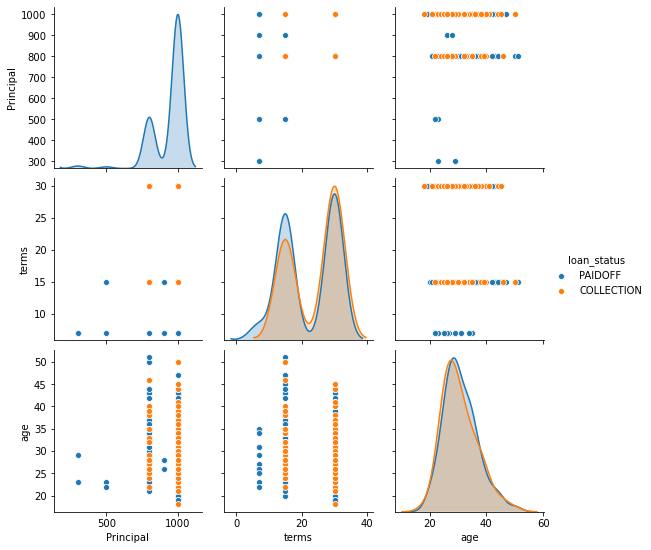

In [13]:
# Plot pair-plot for bi-variate
sb.pairplot(df[['Principal', 'terms', 'age', 'loan_status']], hue='loan_status');

#### When set Principal and terms to Continuous variables, seem not work because too few unique values. Only age work well

In [14]:
# Create a function to draw bi-variate categorical - categorical analysis
def plot_bivariate_analysis_categorical_variables(df, categorical_cols, y_col, target_col, order_sort, order_rename, size_height=6, size_width=6):
    # Remove y_col in cate_cols (if it have)
    cate_cols = categorical_cols.copy()
    try:
        cate_cols.remove(y_col)
    except Exception:
        pass

    # Setup
    y_unique = df[y_col].unique().tolist()
    n = len(y_unique)
    m = len(cate_cols)

    fig, axes = plt.subplots(m,n, figsize=(n*size_width, m*size_height))
    ax = axes.flatten()

    # Main loops plot function
    i = 0
    for x_col in cate_cols:
        # Find y_share for seting y_lim
        y_share_max = df.groupby([x_col, y_col]).size().reset_index()[0].max()*1.1
        for unique in y_unique:
            df_by_y = df[df[y_col]==unique]
            plot = plot_category_count_hue_stacked(df_by_y, x_col, target_col, order_sort, order_rename, ax=ax[i])
            plot.set_ylim([0, y_share_max])
            plot.set_title(x_col + ' - ' + y_col + ' = ' + str(unique))
            i += 1
    plt.suptitle('Bi-variate Analysis Categorical - Categorical, split by '+y_col, size=20, y=0.93)
    plt.show()

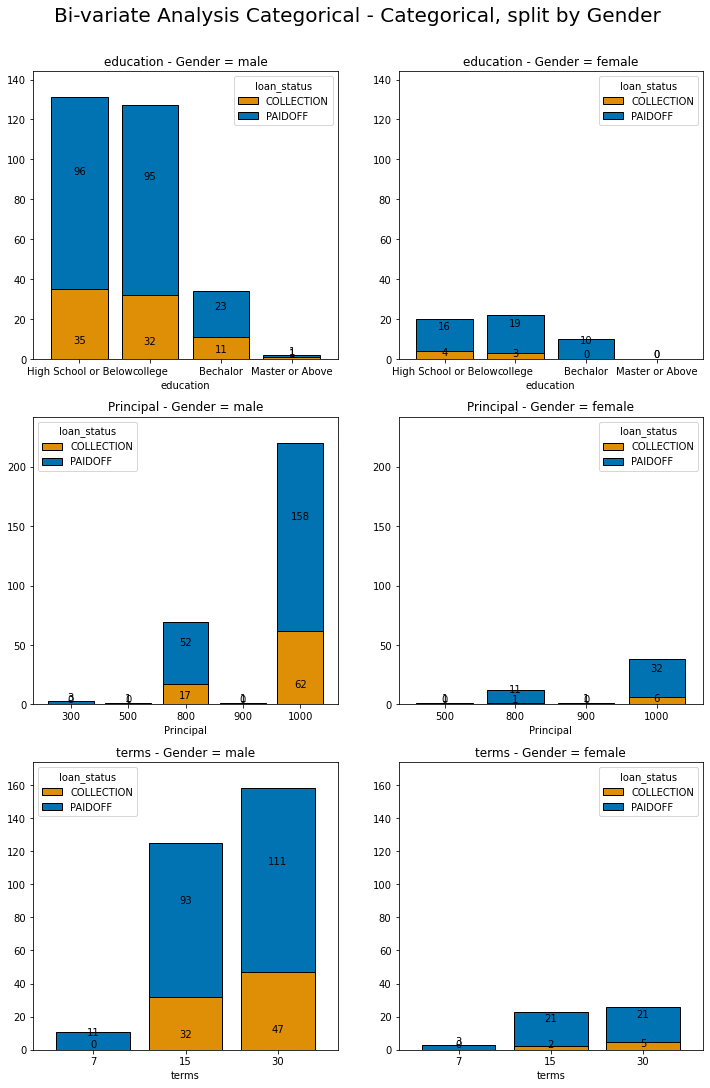

In [15]:
cate_bivariate_cols = ['education', 'Principal', 'terms', 'Gender']
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'Gender', target_col, order_sort, order_rename)

### Bi-variate Analysis split by Gender: 
- It seem female PAIDOFF loan in high probability than male

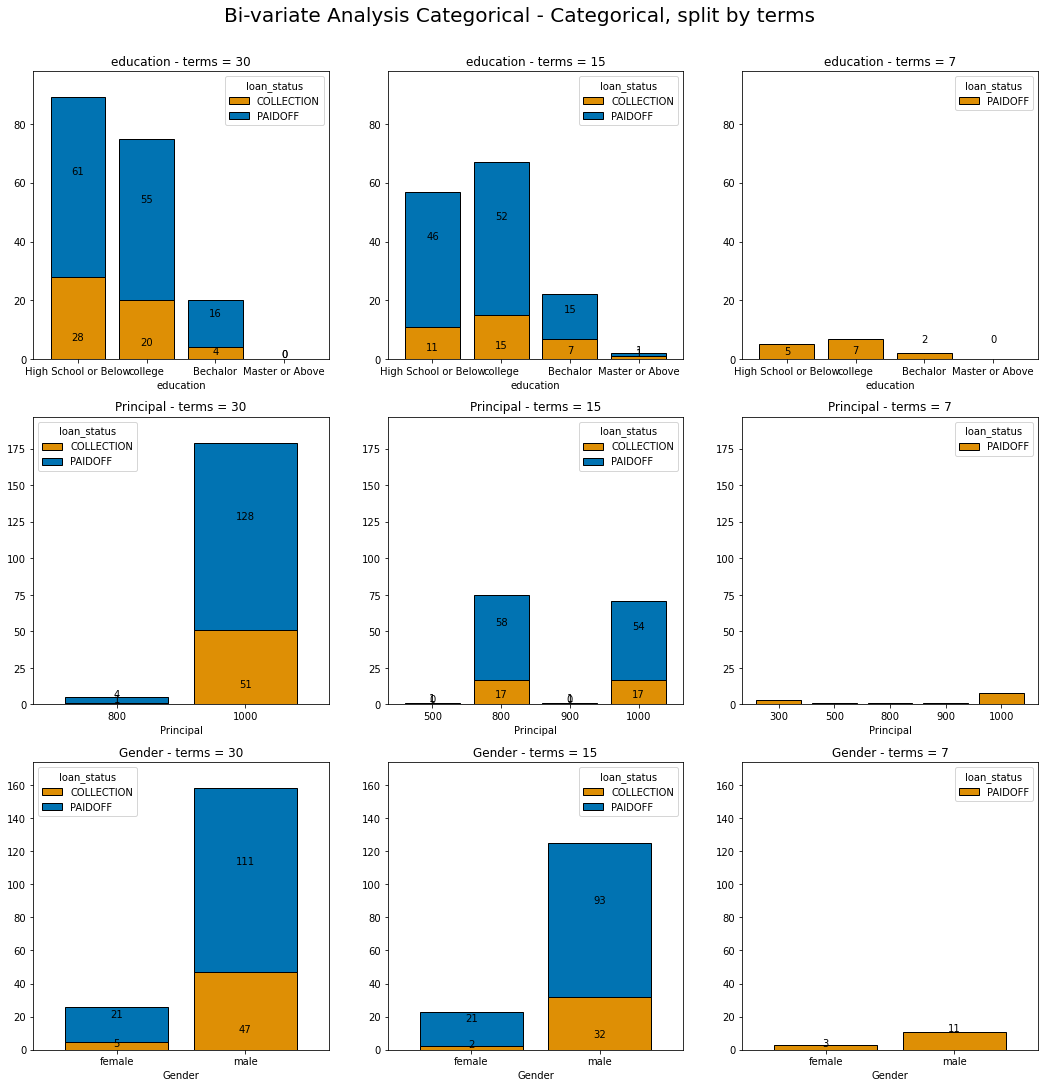

In [16]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'terms', target_col, order_sort, order_rename)

### Bi-variate Analysis split by terms: 
- terms 7 days have fully PAIDOFF

- ratio COLLECTION : PAIDOFF no clear show in terms 30, 15 due to imbalance dataset

- Create dummy for only terms 15, 30 is enough. For example: (1,0) is term-15; (0,1) is term-30; (0,0) is term-7

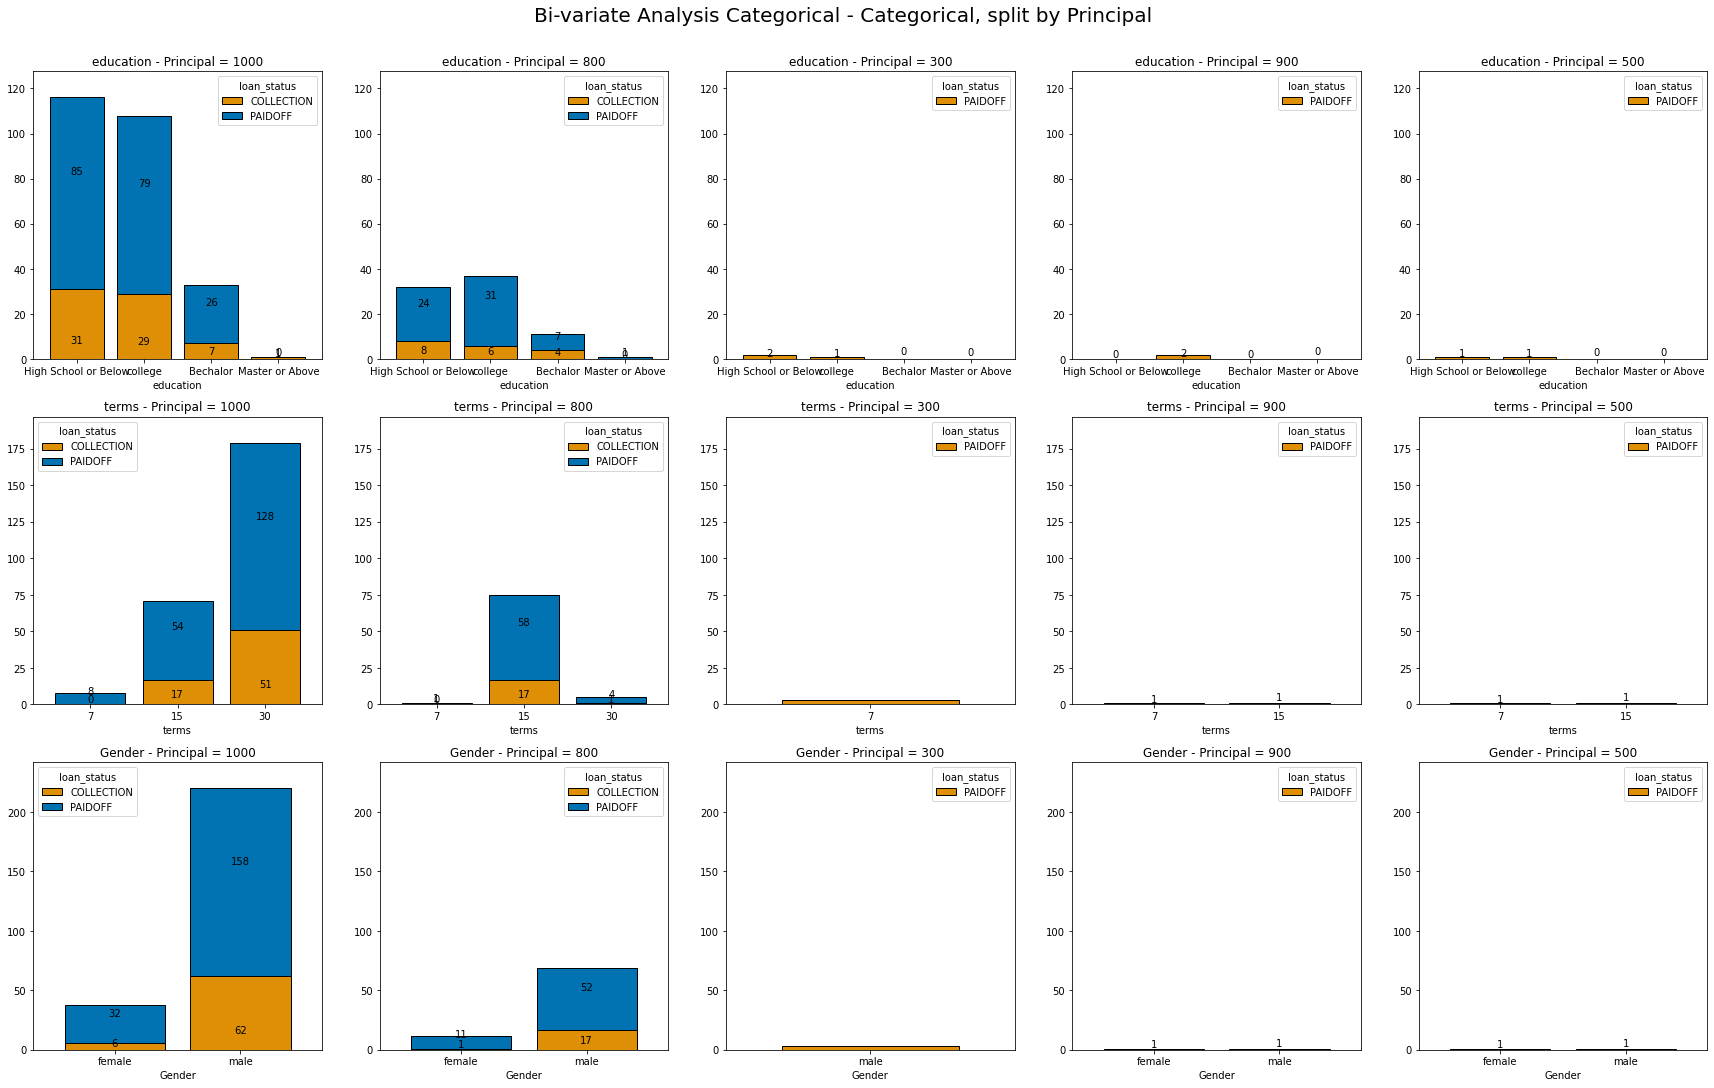

In [17]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'Principal', target_col, order_sort, order_rename)

### Bi-variate Analysis split by Principal:
- Principal 300, 900, 500 payoff all

- Create 2 dummies Principal_800, Principal_1000 is enough

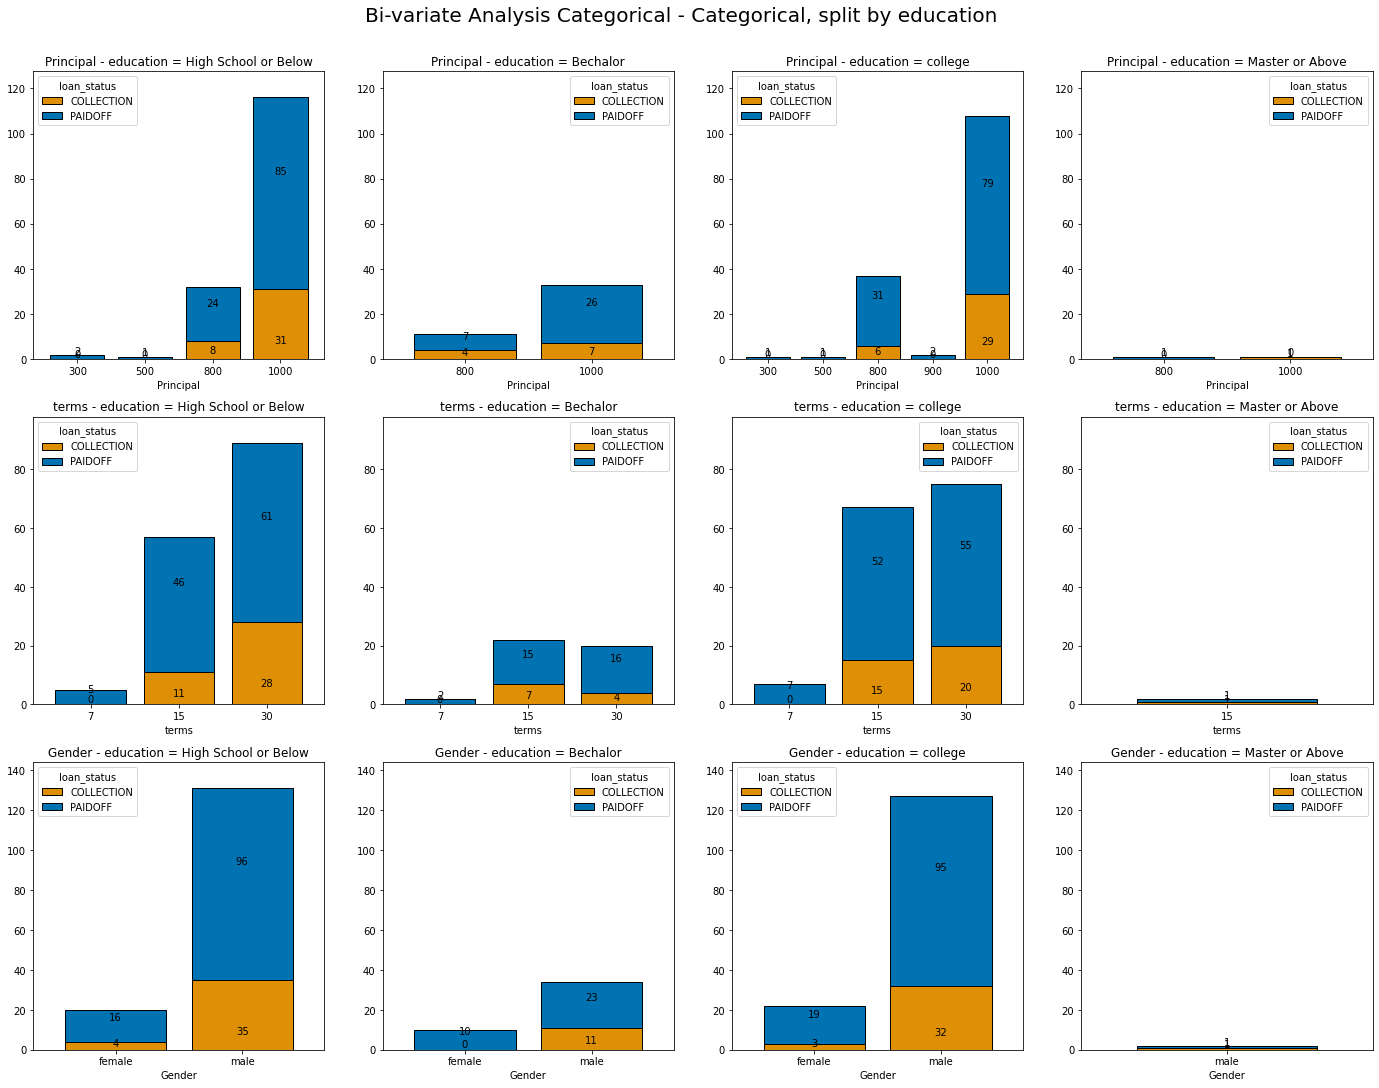

In [18]:
plot_bivariate_analysis_categorical_variables(df, cate_bivariate_cols, 'education', target_col, order_sort, order_rename)

### Bi-variate Analysis split by education:
- Very few sample for Master or above education

- Create 3 dummies is enough

## Feature Selection, Feature Extraction more

In [19]:
# Because we choose feature base on what we analysis, so we only need get dummies and choose dummies_name we want, no need to get all feature like One-hot extraction
def convert_variable(df):
    df_new = df.copy()
    df_new = pd.get_dummies(df_new, columns=['loan_status','Principal', 'terms', 'education', 'Gender'])

    # Choose only what want through analysis
    cate_new = ['loan_status_COLLECTION', 'age', 'Principal_800', 'Principal_1000', 'terms_15', 'terms_30', 
                'education_High School or Below', 'education_college', 'education_Bechalor', 'Gender_male']

    # Some more feature extraction from eff_date and due_date
    df_new = df_new[cate_new]
    df_new['eff_day_first_third'] = df['eff_day'].map(lambda x: 1 if x in [9, 10, 11] else 0)
    df_new['eff_weekend'] = df['eff_dayofweek'].map(lambda x: 1 if x in [4, 5, 6] else 0)
    df_new['due_day_first_third'] = df['due_day'].map(lambda x: 1 if x in [8, 9, 10] else 0)
    df_new['due_day_second_third'] = df['due_day'].map(lambda x: 1 if x in [23, 24, 25] else 0)
    df_new['due_middle_week'] = df['due_dayofweek'].map(lambda x: 1 if x in [1, 2, 3] else 0)
    df_new['due_weekofmonth_2_4'] = df['due_weekofmonth'].map(lambda x: 1 if x in [2, 4] else 0)
    df_new['due_month_9'] = df['due_month'].map(lambda x: 1 if x == 9 else 0)
    df_new['due_month_10'] = df['due_month'].map(lambda x: 1 if x == 10 else 0)

    return df_new

train = convert_variable(df)
test = convert_variable(df_test)

# We treat only age be Continuous variable, so only normalize it
std_scaler = StandardScaler()
train['age'] = std_scaler.fit_transform(train[['age']])
test['age'] = std_scaler.transform(test[['age']])

# Train, test data after all feature selection
X_train, y_train = train.drop(columns='loan_status_COLLECTION'), train['loan_status_COLLECTION']
X_test, y_test = test.drop(columns='loan_status_COLLECTION'), test['loan_status_COLLECTION']
data_train = (X_train, y_train, 'final data')
data_test = (X_test, y_test)

## Train model and using Cross Validation method to get result

In [20]:
# Create a function to get all fpr, tpr for ROC chart and other metrics: accuracy, balanced_accuracy, precision, recall, f1
def result_cv_model(model, data_train, feature_selected=None, rebalance_method=None, cv=5):
    # Get X, y with feature_selected
    X_full, y, name_data = data_train
    if feature_selected == None:
        X = X_full
    else:
        X = X_full[feature_selected]

    # Kfold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    accuracy, balanced_accuracy, precision, recall, f1 = [], [], [], [], []

    for train, test in kfold.split(X, y):
        if rebalance_method == None:
            X_train, y_train = X.iloc[train], y.iloc[train]
        else:
            X_train, y_train = rebalance_method.fit_resample(X.iloc[train], y.iloc[train])
        X_test, y_test = X.iloc[test], y.iloc[test]

        # Get FPR, TPR for ROC chart + AUC
        try:
            y_proba = model.fit(X_train, y_train).decision_function(X_test)
        except Exception:
            y_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, y_proba, drop_intermediate=False)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0
        tprs.append(interp_tpr)

        # Get other metrics: accuracy, balanced_accuracy, precision, recall, f1
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        balanced_accuracy.append(balanced_accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1
    mean_auc = auc(mean_fpr, mean_tpr)

    mean_accuracy = np.mean(accuracy, axis=0)
    mean_balanced_accuracy = np.mean(balanced_accuracy, axis=0)
    mean_precision = np.mean(precision, axis=0)
    mean_recall = np.mean(recall, axis=0)
    mean_f1 = np.mean(f1, axis=0)

    return {'accuracy': mean_accuracy, 'balanced_accuracy': mean_balanced_accuracy, 
            'precision': mean_precision, 'recall': mean_recall, 'f1': mean_f1, 'roc_auc': mean_auc,
            'fpr': mean_fpr, 'tpr': mean_tpr}

# Create a function to plot ROC with result above
def plot_cv_roc(result, name_model, name_rebalance_method):
    mean_fpr = result['fpr']
    mean_tpr = result['tpr']
    mean_auc = result['roc_auc']

    plt.plot(mean_fpr, mean_tpr, lw=(mean_auc-0.5)*5, label=name_model+' : {:.2f}'.format(mean_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title('ROC chart on resample method = ' + name_rebalance_method)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [21]:
# learning_rate=0.1, n_estimators=200, random_state=random

In [22]:
random = 0
models_test = [
                (LogisticRegression(random_state=random), 'Logistic Regression'),
                (LinearDiscriminantAnalysis(), 'LDA'),
                (QuadraticDiscriminantAnalysis(), 'QDA'),
                (RandomForestClassifier(random_state=random), 'Random Forest'),
                (GradientBoostingClassifier(random_state=random), 'Boosting'),
                (SVC(kernel='linear'), 'SVM linear'),
                (SVC(kernel='poly', degree=2), 'SVM poly-2'),
                (SVC(kernel='poly', degree=3), 'SVM poly-3'),
                (SVC(kernel='rbf'), 'SVM radial'),
                (KNeighborsClassifier(), 'KNN')
                # (RandomForestClassifier(random_state=random), 'Balanced Random Forest'),
                # (RUSBoostClassifier(random_state=random), 'Balanced Boosting')
            ]

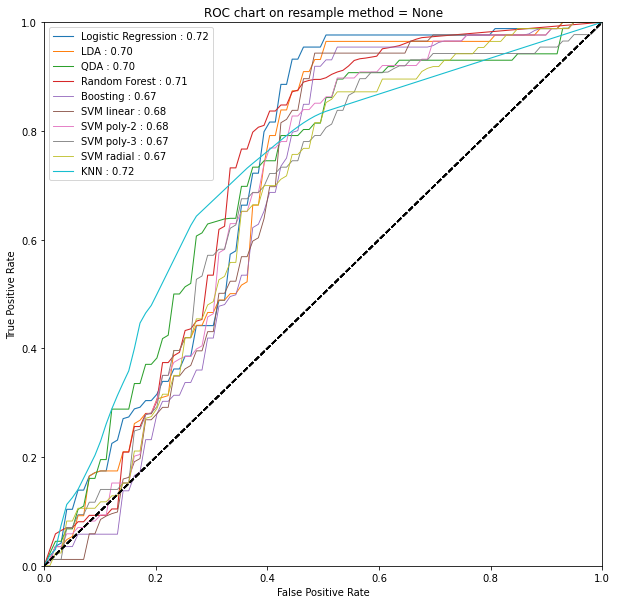

,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
KNN,0.731429,0.588172,0.461688,0.303268,0.361938,0.718316
Random Forest,0.690973,0.561249,0.351497,0.303268,0.321039,0.712052
QDA,0.725300,0.580040,0.295599,0.290850,0.272575,0.704757
Boosting,0.673292,0.497914,0.238073,0.149673,0.182623,0.670212
LDA,0.696687,0.506033,0.271154,0.127451,0.170884,0.699696
SVM poly-3,0.685176,0.478871,0.180769,0.069281,0.095902,0.673873
Logistic Regression,0.731222,0.494457,0.240000,0.023529,0.040404,0.718624
SVM poly-2,0.711097,0.476709,0.028571,0.011111,0.016000,0.683189
SVM linear,0.739876,0.492308,0.000000,0.000000,0.000000,0.678210
SVM radial,0.728489,0.484615,0.000000,0.000000,0.000000,0.667960


In [23]:
# Base case data_train
plt.figure(figsize=(10,10))
score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for model, name_model in models_test:
    result_model = result_cv_model(model, data_train, feature_selected=None, rebalance_method=None, cv=5)
    plot_cv_roc(result_model, name_model, 'None')
    result_model.pop('fpr')
    result_model.pop('tpr')
    score_table.loc[name_model] = result_model
plt.show()
display(score_table.sort_values(by='f1', ascending=False))

### Through the result above:
- Because main purpose to predict right and as much as we can about COLLECTION cases, so we target highest score on f1, which = harmonic_mean_of(precision, recall)

- Balanced_accuracy is another good metric because it = average_of(precision, recall) = 1/2*(precision, recall)

- KNN (default parameter) have best f1 result is 36.2%, recall 30%, precision 46% for COLLECTION, meaning model predict only right 30% COLLECTION in total COLLECTION cases, and when predict COLLECTION 46% right

- We also can see through accuracy 73% but balanced_accuracy only 58.8% (higher a little than 50% luck)

- The basic linear algorithm is Logistic Regression have very bad f1 (4%), recall only 2.3% although accuracy total 73%. 

- This can show imbalance data set (75% PAIDOFF) make model seem to predict all is PAIDOFF to get high accuracy but about predict exactly COLLECTION, if FAIL.

--> Try to use resample for **Re-balance** data_train before fiting model, we have 2 choices: **Oversampling** or **Undersampling**

## Re-balance data

In [24]:
# Create multiple rebalance method to test
over_sample_1 = [over_sampling.RandomOverSampler(random_state=random), 'Over Sample - Random']
over_sample_2 = [over_sampling.SMOTE('minority', random_state=random), 'Over Sample - SMOTE']
over_sample_3 = [over_sampling.SVMSMOTE(random_state=random), 'Over Sample - SVMSMOTE']
over_sample_4 = [combine.SMOTETomek(random_state=random), 'Over Sample - SMOTETomek']
under_sample_1 = [under_sampling.RandomUnderSampler(random_state=random), 'Under Sample - Random']
under_sample_2 = [under_sampling.TomekLinks(), 'Under Sample - TomekLinks']

rebalance_methods = [over_sample_1, over_sample_2, over_sample_3, over_sample_4, under_sample_1, under_sample_2]

In [25]:
# Data_train + rebalance
for method_list in rebalance_methods:
    method, method_name = method_list
    print('Rebalance method: ' + method_name)
    score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    for model, name_model in models_test:
        result_model = result_cv_model(model, data_train, feature_selected=None, rebalance_method=method, cv=5)
        # plot_cv_roc(result_model, name_model, 'None')
        result_model.pop('fpr')
        result_model.pop('tpr')
        score_table.loc[name_model] = result_model
    display(score_table.sort_values(by='f1', ascending=False))
    print('')

Rebalance method: Over Sample - Random


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.656149,0.744746,0.413162,0.920261,0.569793,0.715589
SVM linear,0.650352,0.744859,0.409807,0.932026,0.568815,0.750456
SVM radial,0.647453,0.726772,0.403862,0.884314,0.553943,0.735965
SVM poly-2,0.647495,0.723467,0.402927,0.873856,0.550712,0.709539
LDA,0.635942,0.719734,0.394949,0.885621,0.545865,0.687324
SVM poly-3,0.653333,0.680455,0.394009,0.733987,0.512285,0.693448
KNN,0.667785,0.646845,0.393433,0.605229,0.472354,0.690062
Boosting,0.615652,0.584842,0.327327,0.523529,0.402666,0.663344
Random Forest,0.676480,0.594532,0.364727,0.431373,0.391689,0.718603
QDA,0.693499,0.560520,0.147690,0.294118,0.196296,0.643105



Rebalance method: Over Sample - SMOTE


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
SVM radial,0.670559,0.707177,0.414382,0.779739,0.540033,0.735620
KNN,0.702195,0.684452,0.436562,0.649673,0.516451,0.735649
Logistic Regression,0.636025,0.685080,0.382289,0.781699,0.511992,0.705734
SVM poly-2,0.650435,0.678532,0.391649,0.733987,0.509971,0.711962
LDA,0.621573,0.667220,0.369740,0.757516,0.496171,0.715581
SVM poly-3,0.667743,0.663009,0.395999,0.652941,0.491684,0.682345
SVM linear,0.630186,0.629764,0.360387,0.628758,0.456850,0.714322
Boosting,0.653416,0.618414,0.368026,0.548366,0.438373,0.682019
Random Forest,0.662112,0.565774,0.339851,0.373856,0.352946,0.695994
QDA,0.716770,0.543904,0.222222,0.199346,0.168469,0.647945



Rebalance method: Over Sample - SVMSMOTE


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
KNN,0.705259,0.679437,0.438272,0.628105,0.510842,0.743078
SVM radial,0.664803,0.679902,0.400811,0.709804,0.509776,0.730986
Logistic Regression,0.659130,0.676709,0.394881,0.711111,0.505952,0.726080
LDA,0.647536,0.672976,0.385746,0.722876,0.501129,0.731898
SVM poly-2,0.653416,0.668904,0.391214,0.699346,0.500233,0.710142
SVM poly-3,0.670600,0.656687,0.397063,0.628758,0.486160,0.675211
SVM linear,0.647453,0.655832,0.379567,0.673203,0.479837,0.717718
Boosting,0.636066,0.587406,0.336086,0.490196,0.395814,0.689949
Random Forest,0.673582,0.573140,0.350003,0.373203,0.356446,0.710200
QDA,0.734079,0.567320,0.446667,0.234641,0.279888,0.659727



Rebalance method: Over Sample - SMOTETomek


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
SVM radial,0.670559,0.707177,0.414382,0.779739,0.540033,0.735613
KNN,0.705176,0.690661,0.443502,0.662092,0.524805,0.740951
LDA,0.636066,0.676835,0.381720,0.757516,0.506231,0.715000
SVM poly-3,0.670559,0.672197,0.403022,0.675163,0.503479,0.679537
SVM poly-2,0.650476,0.670940,0.388634,0.711111,0.501302,0.708840
Logistic Regression,0.627329,0.663474,0.371490,0.734641,0.492645,0.706259
SVM linear,0.633085,0.635646,0.364365,0.640523,0.463055,0.712935
Boosting,0.650435,0.608245,0.355603,0.524183,0.421791,0.694286
Random Forest,0.664845,0.586840,0.349982,0.431373,0.380425,0.703598
QDA,0.734079,0.598994,0.285714,0.328758,0.254326,0.738568



Rebalance method: Under Sample - Random


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
SVM radial,0.650269,0.736287,0.407940,0.907190,0.562253,0.737124
Logistic Regression,0.650393,0.732655,0.408071,0.896078,0.560538,0.727600
SVM linear,0.635859,0.730304,0.398275,0.918301,0.555375,0.744072
KNN,0.679130,0.708660,0.417388,0.767320,0.539077,0.727559
LDA,0.627288,0.706373,0.385894,0.862745,0.532608,0.704802
SVM poly-2,0.635859,0.699284,0.389006,0.825490,0.527827,0.707899
SVM poly-3,0.630062,0.676295,0.379060,0.767974,0.507184,0.725681
Random Forest,0.653251,0.633270,0.369229,0.593464,0.451905,0.717759
Boosting,0.618344,0.616805,0.346602,0.614379,0.442608,0.680647
QDA,0.722402,0.570525,0.296115,0.267974,0.253333,0.706574



Rebalance method: Under Sample - TomekLinks


,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
Random Forest,0.690807,0.587657,0.366282,0.383007,0.371653,0.715414
KNN,0.713954,0.588185,0.399890,0.337908,0.362332,0.721321
LDA,0.696687,0.548932,0.346736,0.255556,0.290476,0.693242
QDA,0.725300,0.580040,0.295599,0.290850,0.272575,0.708381
Boosting,0.644513,0.498152,0.223037,0.207843,0.214424,0.670532
SVM poly-3,0.688033,0.508183,0.284524,0.150980,0.194357,0.653665
Logistic Regression,0.716936,0.507617,0.306667,0.092157,0.135325,0.706705
SVM poly-2,0.699627,0.492119,0.366667,0.080392,0.113056,0.666454
SVM linear,0.719876,0.504274,0.066667,0.077778,0.071795,0.695254
SVM radial,0.716936,0.476923,0.000000,0.000000,0.000000,0.677790


### Result after using rebalance method:
- We can see f1 sore, balanced_accuracy improved significantly, with Oversample_random, we receive 92% recall and 41.5% precision, balanced_accuracy reach to 74.6%

- Accuracy drop to 66%, it seem trade off between prediction more COLLECTION cases vs average prediction of all IMBALANCE data_set (COLLECTION + PAIDOFF)

- Over sample methods seem work better than Under sample methods because of number of training sample only 350.

- Suggest that use Over Sample - Random

- Suggest that Linear Regression can work well in this case. Linear methods use in this case is: Logistic Regression (LR), SVM Linear (SVML)

--> Take methods: Logistic Regression (LR), SVM Linear (SVML) SVM Raial (SVMR), then process tuning parameter for geting better result

In [57]:
def rename_keys(dic, pattern):
    return dict([(keys.split(pattern)[1], values) for keys, values in dic.items()])

In [77]:
lr_model = LogisticRegression(random_state=random)
svml_model = SVC(kernel='linear', random_state=random)
svm2_model = SVC(kernel='poly', degree=2, random_state=random)
svmr_model = SVC(kernel='rbf', random_state=random)
qda_model = QuadraticDiscriminantAnalysis()
rdn_forest_model = RandomForestClassifier(random_state=random)
boosting_model = GradientBoostingClassifier(random_state=random)

model_tunning = [(lr_model, 'Linear Regression'), 
                 (svml_model, 'SVM - Linear'),
               #   (svm2_model, 'SVM - Poly-2'),
               #   (qda_model, 'QDA'),
               #   (rdn_forest_model, 'Random Forest'), 
               #   (boosting_model, 'Boosting'),
                 (svmr_model, 'SVM - Radial')
            ]

In [78]:
param_grid_lr = {'model__penalty': ['l1', 'l2'],
              'model__C': [0.01, 0.1, 1, 5, 10, 15, 20],
              'model__solver': ['liblinear', 'newton-cg'],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_svm_linear = {'model__kernel': ['linear'],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_svm_poly_2 = {'model__kernel': ['poly'],
              'model__degree': [2],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }           
param_grid_svm_radial = {'model__kernel': ['rbf'],
              'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 50],
              'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
              'model__class_weight': ['balanced'],
              'model__random_state': [random]
            }
param_grid_qda = {'model__reg_param': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
            }
param_grid_rdn_forest = {'model__n_estimators': [200, 300, 500],
              'model__criterion': ['gini', 'entropy'],
              'model__max_features': [2, 3, 5, 'sqrt', 'log2'],
              'model__class_weight': ['balanced']
            }
param_grid_boosting = {'model__n_estimators': [200, 300, 500],
              'model__learning_rate': [0.01, 0.1],
              'model__max_depth': [1,2,3]
            }

params = [param_grid_lr, 
          param_grid_svm_linear,
        #   param_grid_svm_poly_2,
        #   param_grid_qda,
        #   param_grid_rdn_forest,
        #   param_grid_boosting, 
          param_grid_svm_radial]

In [79]:
models_final = []
for model_list, param in zip(model_tunning, params):
    # param = params[i]
    model, model_name = model_list
    pipeline = Pipeline([('over_sampling', over_sample_1[0]), 
                     ('model', model) ])
    search = GridSearchCV(pipeline, param, cv=5, scoring='f1')
    search.fit(X_train, y_train)
    best_param = rename_keys(search.best_params_, 'model__')
    model_tunned = model.set_params(**best_param)
    models_final.append((model_tunned, model_name))
models_final

[(LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', random_state=0,
                     solver='liblinear'),
  'Linear Regression'),
 (SVC(C=0.1, class_weight='balanced', kernel='linear', random_state=0),
  'SVM - Linear'),
 (SVC(C=0.1, class_weight='balanced', degree=2, kernel='poly', random_state=0),
  'SVM - Poly-2'),
 (QuadraticDiscriminantAnalysis(reg_param=0.3), 'QDA'),
 (RandomForestClassifier(class_weight='balanced', criterion='entropy',
                         max_features=2, n_estimators=300, random_state=0),
  'Random Forest'),
 (GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=200,
                             random_state=0),
  'Boosting'),
 (SVC(C=5, class_weight='balanced', gamma=0.01, random_state=0),
  'SVM - Radial')]

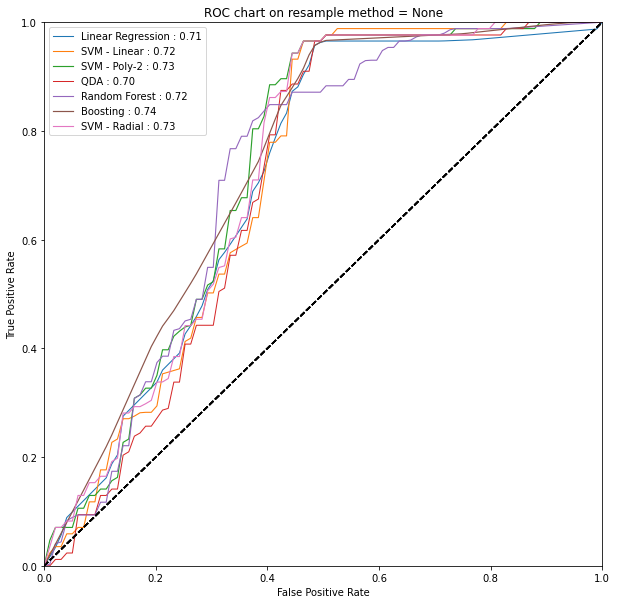

,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
SVM - Linear,0.653251,0.757680,0.415183,0.965359,0.580627,0.716231
SVM - Poly-2,0.653251,0.757680,0.415183,0.965359,0.580627,0.731238
QDA,0.653251,0.757680,0.415183,0.965359,0.580627,0.702360
SVM - Radial,0.653251,0.757680,0.415183,0.965359,0.580627,0.725734
Linear Regression,0.638799,0.748064,0.405122,0.965359,0.570658,0.711972
Boosting,0.638799,0.748064,0.405122,0.965359,0.570658,0.738708
Random Forest,0.673582,0.592609,0.360682,0.431373,0.390204,0.722302


In [80]:
# models_final = [(lr_model_final, 'Linear Regression'), (svml_model_final, 'SVM - Linear'), (svmr_model_final, 'SVM - Radial')]
plt.figure(figsize=(10,10))
score_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
for model, name_model in models_final:
    result_model = result_cv_model(model, data_train, feature_selected=None, rebalance_method=over_sample_1[0], cv=5)
    plot_cv_roc(result_model, name_model, 'None')
    result_model.pop('fpr')
    result_model.pop('tpr')
    score_table.loc[name_model] = result_model
plt.show()
display(score_table.sort_values(by='f1', ascending=False))

## Run data_set and final result

In [81]:
def run_test_model(model, data_train, data_test, feature_selected=None, rebalance_method=None):
    # Get X_train, X_test, y_train, y_test with feature_selected
    X_train_full, y_train, name_data = data_train
    X_test_full, y_test = data_test

    if feature_selected == None:
        X_train = X_train_full
        X_test = X_test_full
    else:
        X_train = X_train_full[feature_selected]
        X_test = X_test_full[feature_selected]

    # Fit model with rebalance_method on training set or not
    if rebalance_method != None:
        X_train, y_train = rebalance_method.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {'accuracy': accuracy, 'balanced_accuracy': balanced_accuracy, 
            'precision': precision, 'recall': recall, 'f1': f1}

In [83]:
test_table = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
for model, name_model in models_final:
    result_model = run_test_model(model, data_train, data_test, feature_selected=None, rebalance_method=over_sample_1[0])
    test_table.loc[name_model] = result_model
display(test_table.sort_values(by='f1', ascending=False))

,accuracy,balanced_accuracy,precision,recall,f1
SVM - Linear,0.685185,0.764286,0.448276,0.928571,0.604651
SVM - Poly-2,0.685185,0.764286,0.448276,0.928571,0.604651
QDA,0.685185,0.764286,0.448276,0.928571,0.604651
SVM - Radial,0.685185,0.764286,0.448276,0.928571,0.604651
Linear Regression,0.592593,0.701786,0.382353,0.928571,0.541667
Boosting,0.592593,0.701786,0.382353,0.928571,0.541667
Random Forest,0.685185,0.601786,0.400000,0.428571,0.413793


## Conclusion: 
- SVM_Linear with tunned parameter work best with f1 score 60%, very good recall 92.8% indicate it predict almost all COLLECTION cases.

- Compare to basic model without tunning parameter, all final model improve significant on f1, recallm precision and balanced_accuracy.

- In this data set, Linear algorithms seem work good.